# Meta Learning


Attempt at figuring out how to do meta gradient descent in flux/zygote.

In [14]:
using Flux, Plots, Distributions, Random, Statistics, ProgressMeter

┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1260


In [23]:
struct SineWave
    amplitude::Float32
    phase_shift::Float32
end
SineWave() = SineWave(rand(Uniform(0.1, 5)), rand(Uniform(0, 2pi)))

(s::SineWave)(x::AbstractArray) = s.amplitude .* sin.(x .+ s.phase_shift)

function Base.show(io::IO, s::SineWave)
    print(io, "SineWave(amplitude = ", s.amplitude, ", phase shift = ", s.phase_shift, ")")
end

In [48]:
function fomaml(
        model; 
        meta_opt=Descent(0.01), 
        inner_opt=Descent(0.02), 
        epochs=30000, 
        n_tasks=3, 
        train_batch_size=10, 
        eval_batch_size=10, 
        eval_interval=10000)

    weights = Flux.params(model)
    dist = Uniform(-5, 5)
    testx = Float32.(range(-5, stop=5, length=50))
    
    kept_grads = IdDict()

    for i in 1:epochs
        prev_weights = deepcopy(weights)

        for _ in 1:n_tasks
            task = SineWave()

            x = Float32.(rand(dist, train_batch_size))
            y = task(x)
            grad = Flux.gradient(() -> Flux.mse(model(x'), y'), weights)

            for w in weights
                w .-= Flux.Optimise.apply!(inner_opt, w, grad[w])
            end

            testy = task(testx)
            grad = Flux.gradient(() -> Flux.mse(model(testx'), testy'), weights)

            # reset weights and accumulate gradients
            for (w1, w2) in zip(weights, prev_weights)
                w1 .= w2
                w = get!(kept_grads, w2, zero(w2))
                w .+= grad[w1]
            end

        end

        for (w1, w2) in zip(weights, prev_weights)
            Flux.Optimise.update!(meta_opt, w1, kept_grads[w2])
        end

        if i % eval_interval == 0
            println("Iteration $(i), evaluating model on random task...\n")
            evalx = Float32.(rand(dist, eval_batch_size))
            eval_model(model, evalx, testx, SineWave())
        end

    end
end

function eval_model(model, x::AbstractArray, testx::AbstractArray, task=SineWave(); 
                    opt=Descent(1e-2), updates=32)
    weights = Flux.params(model)
    prev_weights = deepcopy(weights)

    y = task(x)
    testy = task(testx)
    init_preds = model(testx')
    test_loss = Flux.mse(init_preds, testy')

    test_losses = Float32[]
    push!(test_losses, test_loss)

    for i in 1:updates
        grads = Flux.gradient(weights) do
            Flux.mse(model(x'), y')
        end
        Flux.Optimise.update!(opt, weights, grads)
        test_loss = Flux.mse(model(testx'), testy')
        push!(test_losses, test_loss)
    end
    final_preds = model(testx')

    Flux.loadparams!(model, prev_weights)

    return (x=x, testx=testx, y=y, testy=testy, 
            initial_predictions=Array(init_preds'),
            final_predictions=Array(final_preds'), 
            test_losses=test_losses)
end

eval_model (generic function with 2 methods)

In [52]:
function plot_eval_data(data::NamedTuple, title="")
    return plot([data.x, data.testx, data.testx, data.testx], 
                [data.y, data.testy, data.initial_predictions, data.final_predictions],
                line=[:scatter :path :path :path],
                label=["Sampled points" "Ground truth" "Before finetune" "After finetune"],
                foreground_color_legend=:white, background_color_legend=:transparent,
                title=title, 
                xlim=(-5.5, 5.5))
end

plot_eval_data (generic function with 2 methods)

SineWave(amplitude = 4.0, phase shift = 1.0)


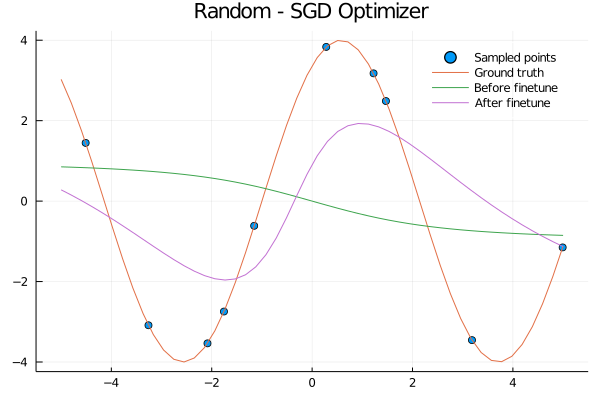

In [57]:
x = rand(Uniform(-5, 5), 10)
    
testx = range(-5; stop=5, length=50)
wave = SineWave(4, 1)

# This model is not trained
random_model =  Chain(
   Dense(1, 64, tanh), 
   Dense(64, 64, tanh), 
   Dense(64, 1)
)

data = eval_model(random_model, x, testx, wave, updates=32, opt=Descent(0.02))

p = plot_eval_data(data, "Random - SGD Optimizer")
plot(p)

Iteration 10000, evaluating model on random task...

SineWave(amplitude = 0.47006336, phase shift = 2.6871102)
Iteration 20000, evaluating model on random task...

SineWave(amplitude = 3.8608885, phase shift = 2.4455326)
Iteration 30000, evaluating model on random task...

SineWave(amplitude = 1.1580108, phase shift = 6.176876)
Iteration 40000, evaluating model on random task...

SineWave(amplitude = 1.5982676, phase shift = 3.737383)
Iteration 50000, evaluating model on random task...

SineWave(amplitude = 3.8132656, phase shift = 0.8245235)
SineWave(amplitude = 4.0, phase shift = 1.0)


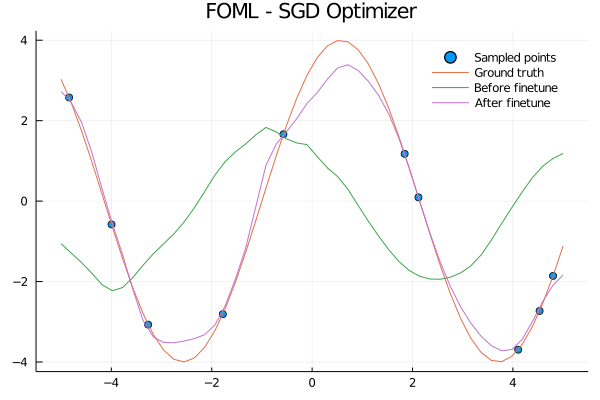

In [59]:
x = rand(Uniform(-5, 5), 10)
testx = range(-5; stop=5, length=50)
wave = SineWave(4, 1)

# This model is not trained
fomaml_model = Chain(
   Dense(1, 64, tanh), 
   Dense(64, 64, tanh), 
   Dense(64, 1))

fomaml(fomaml_model, meta_opt=Descent(0.01), inner_opt=Descent(0.02), epochs=50_000, n_tasks=3)

data = eval_model(fomaml_model, x, testx, wave, updates=32, opt=Descent(0.02))

p = plot_eval_data(data, "FOML - SGD Optimizer")
plot(p)

In [73]:
function reptile(model; meta_opt=Descent(0.1), inner_opt=Descent(0.02), epochs=30_000, 
                 train_batch_size=10, eval_batch_size=10, eval_interval=1000)

    weights = Flux.params(model)
    dist = Uniform(-5, 5)
    testx = Float32.(range(-5, stop=5, length=50))
    x = testx

    for i in 1:epochs
        prev_weights = deepcopy(weights)
        task = SineWave()

        # Train on task for k steps on the dataset
        y = task(x)
        for idx in Iterators.partition(randperm(length(x)), train_batch_size)
            grads = Flux.gradient(weights) do
                Flux.mse(model(x[idx]'), y[idx]')
            end
            Flux.Optimise.update!(inner_opt, weights, grads)
        end

        # Reptile update
        for (w1, w2) in zip(weights, prev_weights)
            gw = Flux.Optimise.apply!(meta_opt, w2, w1 - w2)
            @. w1= w2 + gw
        end

        if i % eval_interval == 0
#             @printf("Iteration %d, evaluating model on random task...\n", i)
            evalx = Float32.(rand(dist, eval_batch_size))
            eval_model(model, evalx, testx, SineWave())
        end

    end
end

reptile (generic function with 1 method)

SineWave(amplitude = 1.0379984, phase shift = 2.3516223)
SineWave(amplitude = 2.4466527, phase shift = 3.1096761)
SineWave(amplitude = 2.9406245, phase shift = 1.27786)
SineWave(amplitude = 3.1547403, phase shift = 0.33950186)
SineWave(amplitude = 4.704894, phase shift = 1.2937018)
SineWave(amplitude = 4.0, phase shift = 1.0)


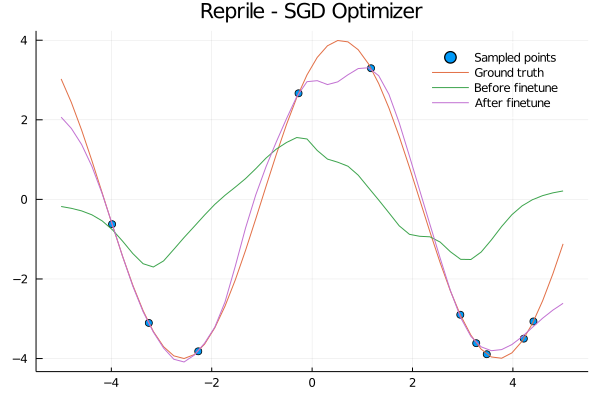

In [77]:
x = rand(Uniform(-5, 5), 10)
testx = range(-5; stop=5, length=50)
wave = SineWave(4, 1)

# This model is not trained
reptile_model = Chain(
   Dense(1, 64, tanh), 
   Dense(64, 64, tanh), 
   Dense(64, 1))

# fomaml(fomaml_model, meta_opt=Descent(0.01), inner_opt=Descent(0.02), epochs=50_000, n_tasks=3)
reptile(reptile_model, meta_opt=Descent(0.1), inner_opt=Descent(0.02), epochs=50_000, eval_interval=10000)

data = eval_model(reptile_model, x, testx, wave, updates=32, opt=Descent(0.02))

p = plot_eval_data(data, "Reprile - SGD Optimizer")
plot(p)